In [5]:
from dask.distributed import Client

client = Client('scheduler:8786')
client

<Client: 'tcp://172.20.0.2:8786' processes=37 threads=111, memory=388.10 GiB>

In [6]:
import dask
import dask.dataframe as dd

In [7]:
from datetime import date, timedelta

In [19]:
data = dd.read_parquet('epi/joined.03.parquet', calculate_divisions=True)
# data['date'] = dd.to_datetime(data['date'])

In [20]:
epsilon_1 = 1.5
epsilon_3 = 10
zeta = 0.05

In [8]:
import numpy as np

In [20]:
import scipy

In [22]:
def grs_unc_bgrel_agg(counts, total_counts, n=7, s=7):
    c = counts
    tc = total_counts
    counts = np.array([0]*(n+s+1)+list(counts)+[counts[-1]]*n, dtype='float')
    total_counts = np.array([total_counts[0]]*(n+s+1)+list(total_counts)+[total_counts[-1]]*n, dtype='float')
    counts += epsilon_1
    total_counts += epsilon_3
    other_counts = total_counts - counts
    delta_counts = epsilon_1 + zeta * counts + (counts*other_counts)**.25 / (counts+other_counts) / 1.414
    c1 = np.minimum(range(n), list(reversed(range(n)))) + 1
    delta_other_counts = epsilon_1 + zeta * other_counts + 0.5 * np.convolve(np.abs(other_counts - np.convolve(other_counts, [1/n]*n, mode='same')), c1**2. / np.sum(c1**2.), mode='same')
    weights = 1/np.sqrt(delta_counts**2 + delta_other_counts**2)
    weights = np.convolve(weights, c1**3, mode='same')
    aweights = np.cumsum(weights / np.sum(weights))
    aweights = aweights[n:] - aweights[:-n]
    acounts = np.cumsum(weights * counts)
    acounts = (acounts[n:] - acounts[:-n]) / aweights
    delta_acounts = np.cumsum(weights**2 * delta_counts**2)
    delta_acounts = np.sqrt(delta_acounts[n:] - delta_acounts[:-n]) / aweights / acounts
    acounts = np.log(acounts)
    oacounts = np.cumsum(weights * other_counts)
    oacounts = (oacounts[n:] - oacounts[:-n]) / aweights
    delta_oacounts = np.cumsum(weights**2 * delta_other_counts**2)
    delta_oacounts = np.sqrt(delta_oacounts[n:] - delta_oacounts[:-n]) / aweights / oacounts
    oacounts = np.log(oacounts)
    rs = (acounts[s:] - acounts[:-s]) / 7
    delta_rs = np.sqrt(delta_acounts[:-s]**2 + delta_acounts[s:]**2) / s
    grs = (acounts[s:] + oacounts[:-s] - acounts[:-s] - oacounts[s:]) / s
    uncs = np.sqrt(delta_acounts[:-s]**2 + delta_oacounts[s:]**2 + delta_acounts[s:]**2 + delta_oacounts[:-s]**2) / s
    prevs = np.exp(acounts[s:] - oacounts[s:])
    puncs = np.sqrt(delta_acounts[s:]**2 + delta_oacounts[s:]**2) * prevs
    return (list(np.convolve(c, [1]*s, mode='full')[s//2:s//2 - s + 1]),
            list(np.convolve(tc, [1]*s, mode='full')[s//2:s//2 - s + 1]),
            ([0]*s + list(np.convolve(c, [1]*s, mode='full')))[s//2:s//2 - 2*s + 1],
            list(delta_counts[n+1:-s-n]), list(prevs[1:-n]), list(puncs[1:-n]),
            list(rs[1:-n]), list(delta_rs[1:-n]), list(grs[1:-n]), list(uncs[1:-n]))

def compute_growth_rates(x):
    x = x.set_index('date')
    x = x[~x.index.duplicated()].asfreq('D')
    x['loc'] = x['loc'].fillna(method = 'ffill')
    x['lin'] = x['lin'].fillna(method = 'ffill')
    x['leaf'] = x['leaf'].fillna(method = 'ffill')
    x['count_total'] = x['count_total'].fillna(method = 'bfill')
    x['count'] = x['count'].fillna(0)
    x['N_7'], x['deltaN_7'], x['N_prev_7'], x['deltaN_prev_7'], x['Prevalence_7'], x['deltaPrevalence_7'], x['rG_7'], x['deltarG_7'], x['G_7'], x['deltaG_7'] = grs_unc_bgrel_agg(x['count'], x['count_total'], n=21, s=7)
    return x

rdata = data.groupby(['loc', 'lin'], sort=False).apply(compute_growth_rates)

/tmp/ipykernel_730/3274284149.py:49: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  rdata = data.groupby(['loc', 'lin'], sort=False).apply(compute_growth_rates)


In [329]:
rdata = rdata.persist()

In [9]:
import pandas as pd

In [378]:
def lincomp(lins):
    def f(x):
        # lins = np.unique(x['lin'])
        dates = np.zeros((len(lins), len(lins)), dtype='datetime64[s]')
        gs = np.zeros((len(lins), len(lins))) + 1e-9
        uncs = np.zeros((len(lins), len(lins))) + 1e3
        for date in np.unique(x.index):
            ixs = np.searchsorted(lins, pd.Series(x.loc[date, 'lin']))
            if len(ixs) > 1:
                d_gs = np.tile(x.loc[date, 'rG_7'], (len(x.loc[date]),1))
                d_uncs = np.tile(x.loc[date, 'deltarG_7'], (len(x.loc[date]),1))
                d_gs = d_gs - d_gs.T
                d_uncs = np.sqrt(d_uncs**2 + d_uncs.T**2)
                ix2s = np.tile(ixs, (len(ixs),1))
                better = np.nonzero(np.abs(d_gs/d_uncs) > np.abs(gs[ix2s,ix2s.T]/uncs[ix2s,ix2s.T]))
                dates[ixs[better[0]], ixs[better[1]]] = np.datetime64(date, 's')
                gs[ixs[better[0]], ixs[better[1]]] = d_gs[better]
                uncs[ixs[better[0]], ixs[better[1]]] = d_uncs[better]
        return pd.Series({'dates':dates, 'gs':gs, 'uncs':uncs})
    return f


noleaves = rdata[(rdata['leaf'] == True)]
lins = np.sort(noleaves['lin'].unique())
test = noleaves[['loc', 'lin', 'rG_7', 'deltarG_7']].groupby('loc').apply(lincomp(lins)).compute()

In [397]:
gs = np.stack(test['gs'])

In [401]:
uncs = np.stack(test['uncs'])

In [415]:
wgs = np.sum(gs / uncs, axis=0) / np.sum(1/uncs, axis=0)
wuncs = np.sum(uncs**2 / uncs**2, axis=0)**.5 / np.sum(1/uncs, axis=0)

In [13]:
import scipy.optimize as opt

In [12]:
import torch

In [14]:
import json

In [819]:
t_wgs = torch.tensor(wgs)
t_wuncs = torch.tensor(wuncs)

def l(x):
    x = torch.tensor(x, requires_grad=True)
    y = torch.tile(x, (3418,1))
    t = torch.sum((t_wgs - (y - y.T))**2./t_wuncs**2.)
    # t += 20*torch.sum(torch.abs(x[1:] - x[:-1]))
    return t.detach().cpu().numpy(), torch.autograd.grad(t, x)[0].detach().cpu().numpy()

In [807]:
x = np.random.normal(size=(3418))*0.01

In [808]:
l(x)

(array(1431026.70145183),
 array([ 9.85022606e+03,  8.78396915e+03,  6.42973527e+02, ...,
        -1.58079307e+02,  9.64818189e+02,  4.02312614e+00]))

In [809]:
result = opt.minimize(l, x0=x, jac=True, options = {'maxiter': 50})

In [810]:
result

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 535900.4856407493
        x: [-1.483e-01 -1.984e-01 ...  6.352e-02 -2.573e-02]
      nit: 50
      jac: [ 2.477e+03 -7.387e+02 ... -3.690e+02 -3.433e+01]
 hess_inv: [[ 9.933e-01 -1.086e-03 ... -2.267e-04  8.073e-05]
            [-1.086e-03  9.971e-01 ...  5.177e-04 -5.149e-04]
            ...
            [-2.267e-04  5.177e-04 ...  1.002e+00 -8.862e-04]
            [ 8.073e-05 -5.149e-04 ... -8.862e-04  1.000e+00]]
     nfev: 53
     njev: 53

In [820]:
result = opt.minimize(l, x0=result.x, jac=True, options = {'maxiter': 10})

In [821]:
result

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 510724.4855316942
        x: [-1.499e-01 -1.931e-01 ...  6.512e-02 -2.537e-02]
      nit: 10
      jac: [-1.486e+03 -2.921e+02 ... -5.953e+01 -6.519e+01]
 hess_inv: [[ 1.000e+00  2.137e-03 ...  6.285e-04  1.633e-04]
            [ 2.137e-03  1.002e+00 ...  5.437e-04  1.776e-04]
            ...
            [ 6.285e-04  5.437e-04 ...  1.000e+00  5.163e-05]
            [ 1.633e-04  1.776e-04 ...  5.163e-05  1.000e+00]]
     nfev: 14
     njev: 14

In [822]:
w = np.tile(result.x, (3418,1)) - np.tile(result.x, (3418,1)).T

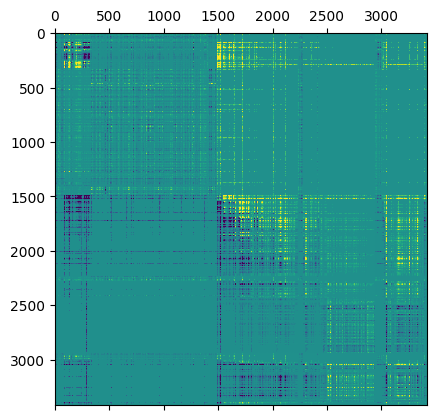

In [823]:
plt.matshow(w/wuncs, clim=(-1,1))

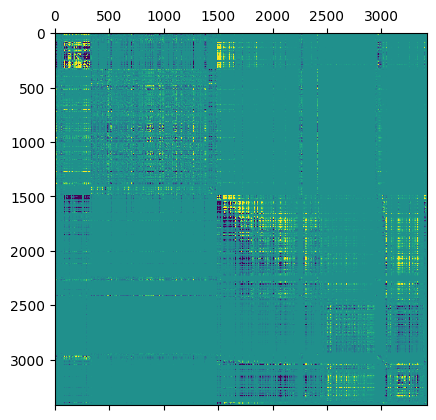

In [824]:
plt.matshow(wgs/wuncs, clim=(-1,1))

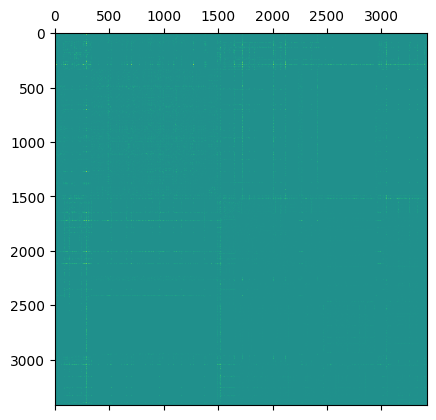

In [825]:
plt.matshow((wgs - w)**2./wuncs, clim=(-1,1))

Text(0.5, 0, 'estimated growth advantage (per day) over reference')

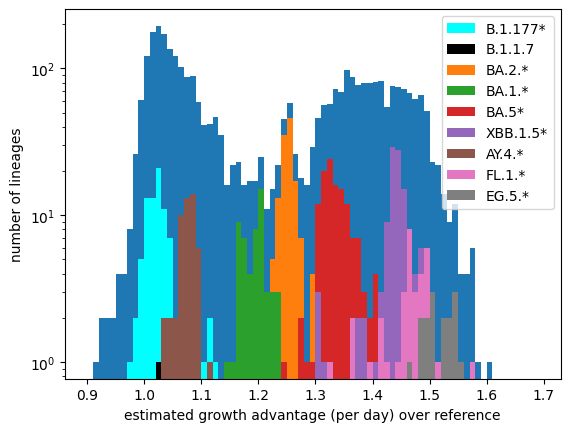

In [831]:
lins = list(lins)
bins = np.arange(0.9, 1.7, 0.01)
x = result.x
x = np.exp(x - x[lins.index('A.1')])
plt.hist(x, bins=bins)
plt.hist([x[lins.index('B.1.177'):lins.index('B.1.178')]], color='cyan', bins=bins, label='B.1.177*')
plt.hist([x[lins.index('B.1.1.7')]], bins=bins, color='black', label='B.1.1.7')
plt.hist(x[lins.index('BA.2'):lins.index('BA.3')], bins=bins,label='BA.2.*')
plt.hist(x[lins.index('BA.1'):lins.index('BA.2')], bins=bins, label='BA.1.*')
plt.hist(x[lins.index('BA.5'):lins.index('BB.1')], bins=bins, label='BA.5*')
plt.hist(x[lins.index('XBB.1.5'):lins.index('XBB.1.6')], bins=bins, label='XBB.1.5*')
plt.hist(x[lins.index('AY.4'):lins.index('AY.5')], bins=bins, label='AY.4.*')
plt.hist(x[lins.index('FL.1'):lins.index('FL.2')], bins=bins, label='FL.1.*')
plt.hist(x[lins.index('EG.5'):lins.index('EG.6')], bins=bins, label='EG.5.*')
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('number of lineages')
plt.xlabel('estimated growth advantage (per day) over reference')

In [15]:
linmuts = dd.read_csv('muts_by_lin.tsv', sep='\t', header=None, dtype=str, names=['lineage', 'mutations'], blocksize='1mb')
# linmuts = linmuts.dropna(subset=['lineage']).repartition('1mb') #.set_index('lineage', npartitions=288*4)

allmuts = list(pd.read_csv('allmuts.tsv', header=None)[0])
allmuts_i = dict(zip(allmuts, range(len(allmuts))))

def onehot(ixs):
    x = np.zeros(len(allmuts))
    x[ixs] = 1
    return x

muts = linmuts['mutations'].apply(json.loads, meta=('x', 'object'))
muts = muts.apply(lambda ms: [allmuts_i[m] for m in ms], meta=('x', 'object'))
muts = muts.map_partitions(lambda x: x.apply(onehot), meta=('x', 'object'))
# muts = muts.apply(lambda ms: [(m == ms[0], ms[0].pop(0))[0] for m in range(len(allmuts))])
muts = muts.compute()

In [388]:
test['gs'][1].shape

(3418, 3418)

In [300]:
test = bdata[(bdata['leaf'] == True) & (bdata['loc'] == 'USA')][['loc', 'lin', 'rG_7', 'deltarG_7']]
len(test)

409769

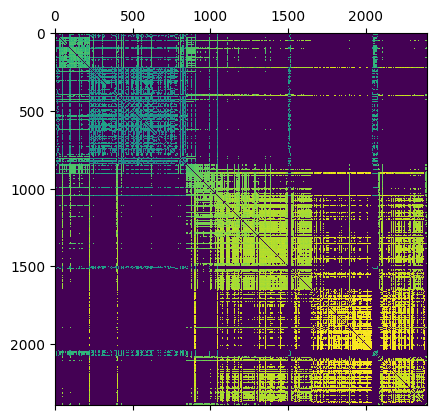

In [327]:
# usa_comp = lincomp(test)
# d[1][np.nonzero(d[2] < 1e3)
plt.matshow(usa_comp[1].astype(float), clim=(1.5e18,None))

In [314]:
plt.matshow(np.datetime64(usa_comp[2]))

ValueError: Could not convert object to NumPy datetime

In [ ]:
test = bdata[(bdata['leaf'] == True) & (bdata['loc'] == 'GBR')][['loc', 'lin', 'rG_7', 'deltarG_7']]
len(test)
d = lincomp(test)
# d[1][np.nonzero(d[2] < 1e3)
plt.matshow(d[1])

In [255]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 59.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 81.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 43.5 MB/s eta 0:00:00


In [256]:
import matplotlib.pyplot as plt

In [159]:
# def lincomp_f(lin1, lin2):
#     dates = np.intersect1d(lin1.index, lin2.index)
#     if len(dates) > 0:
#         gs = lin1.reindex(dates)['rG_7'] - lin2.reindex(dates)['rG_7']
#         uncs = np.sqrt(lin1.reindex(dates)['deltarG_7']**2. + lin2.reindex(dates)['deltarG_7']**2.)
#         best = np.argmax(np.abs(gs)/uncs)
#         return dates[best], gs[best], uncs[best]
#     return None, None, None

# def lincomp(x):
#     lins = np.unique(x['lin'])
#     return lins, np.nan_to_num(np.transpose([[lincomp_f(x[x['lin'] == lin1], x[x['lin'] == lin2]) for lin2 in lins] for lin1 in lins], [2,0,1]), 0)
#     # lings = np.array([x[x['lin'] == lin]['rG_7'] for lin in lins])
#     # linuncs = np.array([x[x['lin'] == lin]['deltarG_7'] for lin in lins])
#     # lings = np.tile([lings], (1,len(lins))) - np.tile([lings], (1,len(lins))).T
#     # linuncs = np.sqrt(np.tile([linuncs], (1,len(lins)))**2. + np.tile([lings], (1,len(linuncs))).T**2.)
#     # best = np.argmax(np.abs(lings) / linuncs, axis=-1)
#     # return lings[:,:,best], linuncs[:,:,best]

In [124]:
test = bdata[(bdata['leaf'] == True) & (bdata['loc'] == 'ZAF')][['loc', 'lin', 'rG_7', 'deltarG_7']]
test

,loc,lin,rG_7,deltarG_7
date,,,,
2022-12-29,ZAF,BQ.1.2,0.003767,0.049799
2022-12-30,ZAF,BQ.1.2,0.003927,0.050083
2022-12-31,ZAF,BQ.1.2,0.004116,0.050403
2023-01-01,ZAF,BQ.1.2,0.004335,0.050725
2023-01-02,ZAF,BQ.1.2,0.004585,0.051016
...,...,...,...,...
2022-10-07,ZAF,BY.1,0.000000,0.047795
2022-10-08,ZAF,BY.1,0.000000,0.047766
2022-10-09,ZAF,BY.1,0.000000,0.047735


In [202]:
lincomp(test)

(57, 57)


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (57,2542) (2542,57) 

In [40]:
rdata[rdata['leaf'] == True][['loc', 'lin', 'rG_7', 'deltarG_7']].groupby('loc', sort=False).apply(lincomp)

,loc,lin,rG_7,deltarG_7
npartitions=1152,,,,
,object,object,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [23]:
bdata = rdata.compute()

In [24]:
bdata

,loc,lin,leaf,count,count_total,N_7,deltaN_7,N_prev_7,deltaN_prev_7,Prevalence_7,deltaPrevalence_7,rG_7,deltarG_7,G_7,deltaG_7
date,,,,,,,,,,,,,,,
2020-03-13,ABW,B+,False,1.0,1.0,1.0,4.0,0.0,1.699914,0.163651,0.040102,0.004407,0.049465,0.005115,0.050505
2020-03-14,ABW,B+,False,0.0,1.0,2.0,5.0,0.0,1.699914,0.163632,0.040086,0.004392,0.049403,0.005098,0.050420
2020-03-15,ABW,B+,False,0.0,1.0,3.0,6.0,0.0,1.699914,0.163621,0.040078,0.004384,0.049361,0.005089,0.050357
2020-03-16,ABW,B+,False,0.0,1.0,3.0,8.0,0.0,1.699914,0.163618,0.040078,0.004382,0.049330,0.005086,0.050309
2020-03-17,ABW,B+,False,1.0,1.0,4.0,9.0,1.0,1.699914,0.169282,0.040395,0.008550,0.048664,0.009948,0.049645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-24,VEN,BA.5+,False,0.0,3.0,1.0,15.0,0.0,1.685868,0.139595,0.032922,-0.007396,0.045838,-0.009038,0.046749
2023-01-25,VEN,BA.5+,False,1.0,3.0,1.0,12.0,0.0,1.685868,0.139952,0.032932,-0.003641,0.046280,-0.006154,0.047165
2022-10-21,VEN,BE.1.2.1,True,1.0,4.0,1.0,4.0,0.0,1.680117,0.124289,0.029926,0.004471,0.048954,0.005017,0.049693


In [125]:
cdata = bdata.reset_index()

In [126]:
cdata = cdata[(cdata['date'] > '2023-01-01') & ((cdata['date'] < '2023-02-01'))]

In [127]:
cdata[['date', 'loc', 'lin', 'leaf', 'rG_7', 'deltarG_7']].to_csv('relnorm_data.csv.gz')

In [25]:
bdata.reset_index(drop=False).to_csv('gr_1003.csv.gz')

In [85]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 58.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 73.8 MB/s eta 0:00:00ta 0:00:01


<Axes: xlabel='date'>

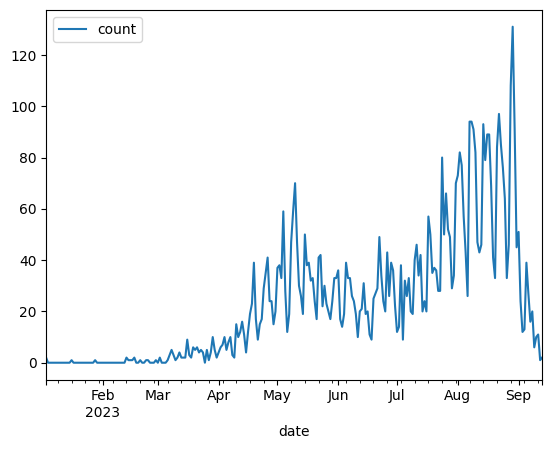

In [304]:
bdata[(bdata['loc'] == 'USA') & (bdata['lin'] == 'FL+')].reset_index(drop=False).plot('date', 'count')

<Axes: xlabel='date'>

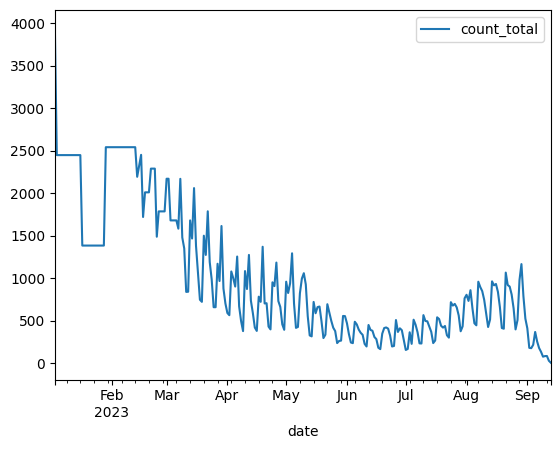

In [305]:
bdata[(bdata['loc'] == 'USA') & (bdata['lin'] == 'FL+')].reset_index(drop=False).plot('date', 'count_total')

In [101]:
import pandas as pd

In [ ]:
b = bdata[(bdata['loc'] == 'GBR') & (bdata['lin'] == 'EG.5+')].reset_index(drop=False)
plt.fill_between(b['date'], b['G_7'] - 1.6*b['deltaG_7'], b['G_7'] + 1.6*b['deltaG_7'], alpha=0.5, label='EG.5+')
plt.plot(b['date'], b['G_7'])
b = bdata[(bdata['loc'] == 'GBR') & (bdata['lin'] == 'FL.3+')].reset_index(drop=False)
plt.fill_between(b['date'], b['G_7'] - 1.6*b['deltaG_7'], b['G_7'] + 1.6*b['deltaG_7'], alpha=0.5, label='FL.3+')
plt.plot(b['date'], b['G_7'])
b = bdata[(bdata['loc'] == 'GBR') & (bdata['lin'] == 'XBB.1+')].reset_index(drop=False)
plt.fill_between(b['date'], b['G_7'] - 1.6*b['deltaG_7'], b['G_7'] + 1.6*b['deltaG_7'], alpha=0.5, label='XBB.1+')
plt.plot(b['date'], b['G_7'])
plt.xlim(pd.to_datetime('2023-02-15'), pd.to_datetime('2023-08-15'))
plt.legend()
plt.ylabel('Growth rate (log daily advantage over background)')
plt.title('Growth rates of circulating variants in Great Britain (90% CI)')
# plt.ylim(-0.5, 0.5)
plt.axhline(0)

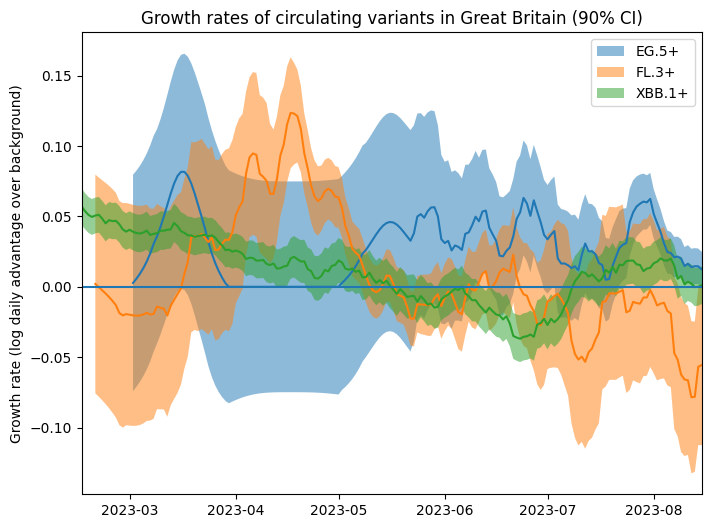

In [119]:
b = bdata[(bdata['loc'] == 'GBR') & (bdata['lin'] == 'EG.5+')].reset_index(drop=False)
plt.fill_between(b['date'], b['G_7'] - 1.6*b['deltaG_7'], b['G_7'] + 1.6*b['deltaG_7'], alpha=0.5, label='EG.5+')
plt.plot(b['date'], b['G_7'])
b = bdata[(bdata['loc'] == 'GBR') & (bdata['lin'] == 'FL.3+')].reset_index(drop=False)
plt.fill_between(b['date'], b['G_7'] - 1.6*b['deltaG_7'], b['G_7'] + 1.6*b['deltaG_7'], alpha=0.5, label='FL.3+')
plt.plot(b['date'], b['G_7'])
b = bdata[(bdata['loc'] == 'GBR') & (bdata['lin'] == 'XBB.1+')].reset_index(drop=False)
plt.fill_between(b['date'], b['G_7'] - 1.6*b['deltaG_7'], b['G_7'] + 1.6*b['deltaG_7'], alpha=0.5, label='XBB.1+')
plt.plot(b['date'], b['G_7'])
plt.xlim(pd.to_datetime('2023-02-15'), pd.to_datetime('2023-08-15'))
plt.legend()
plt.ylabel('Growth rate (log daily advantage over background)')
plt.title('Growth rates of circulating variants in Great Britain (90% CI)')
# plt.ylim(-0.5, 0.5)
plt.axhline(0)

In [ ]:
bdata.to_csv('epi/gr10.csv.gz')

import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (8,6)

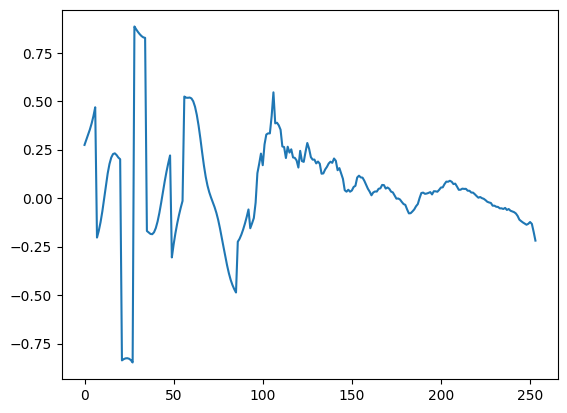

In [181]:
plt.plot(b['grs'] / b['uncs'])

In [40]:
# data['prev'] = data['count'] / data['count_total']
# (data['count']*data['count_total'])**0.25 / (data['count']+data['count_total'])
# np.sqrt(np.sqrt(x*b)) / (x+b) / 1.414
data['count'] = data['count'] + epsilon_1
data['count'] = data['count'] + epsilon_3
data['delta_count'] = epsilon_2 + zeta * data['count'] + (data['count']*data['count_total'])**.25 / (data['count']+data['count_total']) / 1.414
data['delta_total_count'] = epsilon_3 + zeta * data['count_total']

In [ ]:
data['P'] = data['count']
data['Q'] = data['count_total'] - data['count']
data['deltaP'] = zeta * data['P']
data['deltaQ'] = zeta * data['Q']
data['P'] += epsilon_1
data['deltaP'] += epsilon_1
data['Q'] += epsilon_2
data['deltaQ'] += epsilon_2
data['S'] = epsilon_3 + gamma * data['cases']

In [61]:
data['R'] = dask.array.log(data['P']) - dask.array.log(data['Q'])
data['det'] = data['S']*data['P']*data['Q']/(data['P'] + data['Q'])**2
data['deltaLogPS'] = dask.array.sqrt(data['det'] + (data['S'] * data['deltaP'])**2) / data['P'] / data['S']
data['deltaLogQS'] = dask.array.sqrt(data['det'] + (data['S'] * data['deltaQ'])**2) / data['Q'] / data['S']
data['Prevalence'] = data['count'] / (epsilon_2 + data['count_total'])
data['deltaR'] = dask.array.sqrt(data['deltaLogPS']**2 + data['deltaLogQS']**2)
data['deltaPrevalence'] = data['Prevalence'] * data['deltaR']
data = data.drop(['det', 'deltaLogPS', 'deltaLogQS', 'P', 'Q', 'deltaP', 'deltaQ', 'S', 'cases'], axis=1)

In [62]:
data['k1'] = data.index + data['date'].astype(str)
data['k2'] = data.index + (data['date'] - timedelta(weeks=1)).astype(str)
data2 = data.drop(['loc', 'lin', 'leaf', 'date', 'population', 'k1'], axis=1).set_index('k2', divisions=data.divisions)
data1 = data.drop(['k2'], axis=1).set_index('k1', divisions=data.divisions)
data = data1.merge(data2, suffixes=['', '_prev'], how='inner', left_index=True, right_index=True) # .drop(['k1', 'k2'], axis=1)

In [63]:
data['R_prev'] = data['R_prev'].fillna(0)
data['deltaR_prev'] = data['deltaR_prev'].fillna(float('inf'))
data['G'] = (data['R'] - data['R_prev']) / 7
data['deltaG'] = dask.array.sqrt(data['deltaR']**2 + data['deltaR_prev']**2) / 7
data = data.drop(['R', 'R_prev', 'deltaR', 'deltaR_prev', 'population', 'Prevalence_prev', 'deltaPrevalence_prev'], axis=1)

In [68]:
def rolling(ns):
    def r(x):
        x = x.set_index('date')
        x = x[~x.index.duplicated()].asfreq('D')
        x['loc'] = x['loc'].fillna(method = 'ffill')
        x['lin'] = x['lin'].fillna(method = 'ffill')
        x['Prevalence'] = x['Prevalence'].fillna(0)
        x['deltaPrevalence'] = x['deltaPrevalence'].fillna(float('inf'))
        x['G'] = x['G'].fillna(0)
        x['deltaG'] = x['deltaG'].fillna(float('inf'))
        x['N'] = x['count'].fillna(0)
        x['deltaN'] = x['count_total'].fillna(0)
        x['N_prev'] = x['count_prev'].fillna(0)
        x['deltaN_prev'] = x['count_total_prev'].fillna(0)
        # needs some work for better NaN handling:
        # weight for each 1/u; weight for set 1/sum 1/u; uncertainty u
        # sqrt( n ) / sum(1/u)
        tPrev = (1 / x['deltaPrevalence']).fillna(0) + 0.01
        wPrev = x['Prevalence'] * tPrev
        tG = (1 / x['deltaG']).fillna(0) + 0.01
        wG = x['G'] * tG
        for n in ns:
            x['Prevalence_'+str(n)] = wPrev.rolling(n, center=True).sum() / tPrev.rolling(n, center=True).sum()
            x['deltaPrevalence_'+str(n)] = (tPrev > 0).rolling(n, center=True).sum()**.5 / tPrev.rolling(n, center=True).sum()
            x['G_'+str(n)] = wG.rolling(n, center=True).sum() / tG.rolling(n, center=True).sum()
            x['deltaG_'+str(n)] = (tG > 0).rolling(n, center=True).sum()**.5 / tG.rolling(n, center=True).sum()
            x['N_'+str(n)] = x['N'].rolling(n, center=True).sum()
            x['deltaN_'+str(n)] = x['deltaN'].rolling(n, center=True).sum()
            x['N_prev_'+str(n)] = x['N_prev'].rolling(n, center=True).sum()
            x['deltaN_prev_'+str(n)] = x['deltaN_prev'].rolling(n, center=True).sum()
        x = x.drop(['count', 'count_prev', 'count_total', 'count_total_prev'], axis=1)
        return x.reset_index()
    return r

ns = [3, 7, 14, 30]
rdata = data.groupby(['loc', 'lin'], sort=False) \
            .apply(rolling(ns), meta={
               'date':'datetime64[ns]', 'loc':'f8', 'lin':'f8', 'leaf':'f8',
              **{b+a+n:'f8' for n in (['']+['_'+str(n) for n in ns]) for a in ['Prevalence', 'G', 'N', 'N_prev'] for b in ['', 'delta']} })

In [28]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 34.5 MB/s eta 0:00:0000:0100:01


In [29]:
import numpy as np
import scipy

In [677]:
# data = dd.read_csv('gr_1003.csv.gz')
sig = data[(data['date'] >= '2023-07') & ~np.isnan(data['G_7'])][['loc', 'lin', 'leaf', 'G_7', 'deltaG_7']].compute()

In [678]:
#sig = data[(data['date'] >= '2023-07') & ~np.isnan(rdata['G_30'])][['loc', 'lin', 'G_30', 'deltaG_30']].compute()
#x^{2}+\pi\ln\left(\frac{\sqrt{3}}{2}\ln\left(x+1\right)+1\right)
sig['snr'] = np.abs(sig['G_7'] / sig['deltaG_7'])
sig['growing'] = sig['G_7'] > 0
sig['sig'] = 0.5 + scipy.special.erf(sig['snr']) / 2
sig['sig'] = np.abs(np.log(sig['sig']) - np.log(1 - sig['sig']))
sig['bsig'] = sig['snr']**2 + 3.13159*np.log(3**.5/2*np.log(sig['snr']+1)+1)
sig['badsig'] = np.isnan(sig['sig']) | ~np.isfinite(sig['sig'])
sig['sig'] = sig['sig'].where(~sig['badsig'], sig['bsig'])
#sig.loc[badsig, 'sig'] = sig.loc[badsig, 'bsig']
sig = sig.drop(['G_7', 'deltaG_7', 'bsig', 'badsig'], axis=1)

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [679]:
sig

,loc,lin,leaf,snr,growing,sig
1321,AUS,XBC.1.1+,False,0.888634,True,2.148967
1322,AUS,XBC.1.1+,False,1.001842,True,2.466115
1323,AUS,XBC.1.1+,False,1.070658,True,2.666236
1324,AUS,XBC.1.1+,False,1.161029,True,2.938123
1325,AUS,XBC.1.1+,False,1.183160,True,3.006349
...,...,...,...,...,...,...
8870238,NZL,XBC.1.6+,False,0.580431,True,1.350034
8870239,NZL,XBC.1.6+,False,0.969672,True,2.374511
8870240,NZL,XBC.1.6+,False,1.118321,True,2.808310
8870241,NZL,XBC.1.6+,False,1.517390,True,4.122859


In [680]:
sig = sig[sig['leaf'] == True].groupby(['loc']).apply(lambda x: x.sort_values('sig', ascending=False).drop_duplicates(['loc', 'lin']).head(32)).set_index(['loc', 'lin'])
sig

leaf       snr  growing       sig
loc lin                                          
ABW XBB.1.5.72  True  1.419673    False  3.778944
    XBB.1.16.6  True  0.814157    False  1.947874
    FL.1.5.1    True  0.771390    False  1.834895
    XBB.1.16    True  0.664506    False  1.559824
    EG.5.1.1    True  0.102058     True  0.230538
...              ...       ...      ...       ...
ZAF XBB.1       True  0.101961    False  0.230319
    HF.1        True  0.101598     True  0.229497
    XBB.2.3.2   True  0.101241     True  0.228690
    GJ.1.1      True  0.101241     True  0.228690
    XCH         True  0.100962     True  0.228059

[1980 rows x 4 columns]

In [681]:
sig.to_csv('significant.csv.gz')

In [65]:
usa = data[data['loc'] == 'USA'].compute()

In [11]:
bdata = dd.read_parquet('epi/joined.28.parquet')

In [12]:
bdata['key'] = bdata['loc'] + bdata['lin'] + bdata['leaf'].astype(str)
bdata = bdata.sort_values('date')
bdata = bdata.set_index('key', npartitions=288*4)

In [13]:
bdata.to_parquet('epi/joined.28.b.parquet')

In [14]:
lens = bdata.map_partitions(len).compute()

In [ ]:
bdata.divisions

In [ ]:
list(zip(bdata.divisions, lens))

In [16]:
bdata.to_parquet('epi/joined2c.parquet')

In [12]:
cdata = data.copy()

In [17]:
data = dd.read_parquet('epi/joined.28.b.parquet', calculate_divisions=True)
data = data.repartition(partition_size='5MB')

In [26]:
usa = data[data['loc'] == 'USA']

In [30]:
gbr = data[data['loc'] == 'GBR']

In [27]:
len(usa)

45217727

In [31]:
len(gbr)

110349

In [28]:
len(data)

46977828

In [18]:
data.to_parquet('epi/joined.28.c.parquet')

In [21]:
data = dd.read_parquet('epi/joined.28.b.parquet', calculate_divisions=True)
data['date'] = dd.to_datetime(data['date'])

In [19]:
bdata.index

Dask Index Structure:
npartitions=288
AFGB.1.1.7True    object
BELBFalse            ...
                   ...  
USAXBJTrue           ...
ZWECFalse            ...
Name: key, dtype: object
Dask Name: sort_index-index, 16 graph layers

In [22]:
data

,loc,date,lin,leaf,count,count_total,population,cases
npartitions=288,,,,,,,,
AFGB.1.1.7True,object,datetime64[ns],object,bool,int64,int64,object,int64
BELBFalse,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
USAXBJTrue,...,...,...,...,...,...,...,...
ZWECFalse,...,...,...,...,...,...,...,...


In [23]:
data['k1'] = data.index + data['date'].astype(str)
data['k2'] = data.index + (data['date'] - timedelta(weeks=1)).astype(str)
data1 = data.set_index('k1', shuffle='disk')
data2 = data.drop(['loc', 'lin', 'leaf', 'date', 'population'], axis=1).set_index('k2', shuffle='disk')
data = data1.merge(data2, suffixes=['', '_prev'], how='inner', left_index=True, right_index=True).drop(['k1', 'k2'], axis=1)

In [ ]:
data.to_parquet('epi/joined.28.c.parquet')

In [30]:
cdata = data1.merge(data2, suffixes=['', '_prev'], how='inner', left_index=True, right_index=True).drop(['k1', 'k2'], axis=1)

In [31]:
cdata.compute()

,loc,date,lin,leaf,count,count_total,population,cases,count_prev,count_total_prev,cases_prev
AFG B.1.1.7True2021-04-25,AFG,2021-04-25,B.1.1.7,True,1,1,38928341,113,1,1,183
AFG B.1.1.7True2021-05-07,AFG,2021-05-07,B.1.1.7,True,4,4,38928341,293,4,4,310
AFG B.1.1.7True2021-05-10,AFG,2021-05-10,B.1.1.7,True,4,5,38928341,221,7,7,114
AFG B.1.1.7True2021-05-14,AFG,2021-05-14,B.1.1.7,True,4,4,38928341,310,3,4,505
AFG B.1.1False2021-04-25,AFG,2021-04-25,B.1.1,False,1,1,38928341,113,1,1,183
...,...,...,...,...,...,...,...,...,...,...,...
ZWE CFalse2020-12-24,ZWE,2020-12-24,C,False,2,7,14862927,112,2,14,300
ZWE CFalse2020-12-27,ZWE,2020-12-27,C,False,1,12,14862927,83,1,4,407
ZWE CFalse2020-12-28,ZWE,2020-12-28,C,False,5,33,14862927,114,1,25,774
ZWE CFalse2021-01-03,ZWE,2021-01-03,C,False,1,4,14862927,407,1,3,839


In [12]:
lens = data.map_partitions(len).compute()

In [31]:
lens[149]

413460

In [ ]:
bdata = data1.merge(data2, suffixes=['', '_prev'], how='inner', left_index=True, right_index=True).drop(['k1', 'k2'], axis=1)

In [41]:
data.get_partition(149).head(3000)

,loc,date,lin,leaf,count,count_total,population,cases,k1,k2
key,,,,,,,,,,
USA BQ.1.1,USA,2022-08-25,BQ.1.1,True,2,3921,836,2,USA BQ.1.1True2022-08-25,USA BQ.1.1True2022-08-18
USA BQ.1.1,USA,2023-02-02,BQ.1.1,True,215,1988,6797,3,USA BQ.1.1True2023-02-02,USA BQ.1.1True2023-01-26
USA BQ.1.1,USA,2023-02-02,BQ.1.1,True,215,1988,88595,53,USA BQ.1.1True2023-02-02,USA BQ.1.1True2023-01-26
USA BQ.1.1,USA,2023-02-02,BQ.1.1,True,215,1988,7426,6,USA BQ.1.1True2023-02-02,USA BQ.1.1True2023-01-26
USA BQ.1.1,USA,2023-02-02,BQ.1.1,True,215,1988,14349,11,USA BQ.1.1True2023-02-02,USA BQ.1.1True2023-01-26
...,...,...,...,...,...,...,...,...,...,...
USA BQ.1.1,USA,2023-02-02,BQ.1.1,False,160,1988,6963,14,USA BQ.1.1False2023-02-02,USA BQ.1.1False2023-01-26
USA BQ.1.1,USA,2023-02-02,BQ.1.1,False,160,1988,29791,54,USA BQ.1.1False2023-02-02,USA BQ.1.1False2023-01-26
USA BQ.1.1,USA,2023-02-02,BQ.1.1,False,160,1988,30725,28,USA BQ.1.1False2023-02-02,USA BQ.1.1False2023-01-26


In [ ]:
for n in range(288):
    print(n)
    bdata.get_partition(n).head(10)

In [ ]:
bdata.to_csv('epi/temp.csv')

In [ ]:
bdata.compute()

In [31]:
data['k1'] = data.index + data['leaf'].astype(str) + data['date'].astype(str)
data.set_index('k1', shuffle='disk', divisions=data.divisions).compute()

,loc,date,lin,leaf,count,count_total,population,cases
k1,,,,,,,,
AFG B.1.1.7True2021-03-21,AFG,2021-03-21,B.1.1.7,True,1,1,38928341,10
AFG B.1.1.7True2021-03-26,AFG,2021-03-26,B.1.1.7,True,1,1,38928341,28
AFG B.1.1.7True2021-04-10,AFG,2021-04-10,B.1.1.7,True,4,4,38928341,125
AFG B.1.1.7True2021-04-20,AFG,2021-04-20,B.1.1.7,True,1,2,38928341,139
AFG B.1.1.7True2021-04-22,AFG,2021-04-22,B.1.1.7,True,1,1,38928341,98
...,...,...,...,...,...,...,...,...
ZWE CFalse2021-01-04,ZWE,2021-01-04,C,False,1,25,14862927,774
ZWE CFalse2021-01-08,ZWE,2021-01-08,C,False,2,29,14862927,871
ZWE CFalse2021-01-10,ZWE,2021-01-10,C,False,1,3,14862927,839


In [32]:
data = cdata

In [26]:
epsilon_1 = 0.5
epsilon_2 = 2
epsilon_3 = 10
gamma = 1.5
zeta = 0.1

In [45]:
data = dd.read_parquet('epi/joined.28.b.parquet', calculate_divisions=True)
data['date'] = dd.to_datetime(data['date'])

In [22]:
usa = data[data['loc'] == 'USA'].compute()

In [17]:
lens = data.map_partitions(len).compute()

In [18]:
lens.max()

2883

In [27]:
# computed = data[['loc', 'date', 'lin', 'date_prev']]
data['P'] = data['count']
data['Q'] = data['count_total'] - data['count']
data['deltaP'] = zeta * data['P']
data['deltaQ'] = zeta * data['Q']
data['P'] += epsilon_1
data['deltaP'] += epsilon_1
data['Q'] += epsilon_2
data['deltaQ'] += epsilon_2
data['S'] = epsilon_3 + gamma * data['cases']

In [28]:
data['R'] = dask.array.log(data['P']) - dask.array.log(data['Q'])
data['det'] = data['S']*data['P']*data['Q']/(data['P'] + data['Q'])**2
data['deltaLogPS'] = dask.array.sqrt(data['det'] + (data['S'] * data['deltaP'])**2) / data['P'] / data['S']
data['deltaLogQS'] = dask.array.sqrt(data['det'] + (data['S'] * data['deltaQ'])**2) / data['Q'] / data['S']
data['Prevalence'] = data['count'] / (epsilon_2 + data['count_total'])
data['deltaR'] = dask.array.sqrt(data['deltaLogPS']**2 + data['deltaLogQS']**2)
data['deltaPrevalence'] = data['Prevalence'] * data['deltaR']
data = data.drop(['det', 'deltaLogPS', 'deltaLogQS', 'P', 'Q', 'deltaP', 'deltaQ', 'S', 'cases'], axis=1)

In [29]:
data['k1'] = data.index + data['date'].astype(str)
data['k2'] = data.index + (data['date'] - timedelta(weeks=1)).astype(str)
data2 = data.drop(['loc', 'lin', 'leaf', 'date', 'population', 'k1'], axis=1).set_index('k2', divisions=data.divisions)
data1 = data.drop(['k2'], axis=1).set_index('k1', divisions=data.divisions)
data = data1.merge(data2, suffixes=['', '_prev'], how='inner', left_index=True, right_index=True) # .drop(['k1', 'k2'], axis=1)

In [30]:
data['R_prev'] = data['R_prev'].fillna(0)
data['deltaR_prev'] = data['deltaR_prev'].fillna(float('inf'))
data['G'] = (data['R'] - data['R_prev']) / 7
data['deltaG'] = dask.array.sqrt(data['deltaR']**2 + data['deltaR_prev']**2) / 7
data = data.drop(['R', 'R_prev', 'deltaR', 'deltaR_prev', 'population', 'Prevalence_prev', 'deltaPrevalence_prev'], axis=1)

In [31]:
usa2 = data[data['loc'] == 'USA'].compute()

In [36]:
usa2

,loc,date,lin,leaf,count,count_total,Prevalence,deltaPrevalence,count_prev,count_total_prev,G,deltaG
USAB.1.1.529.2.12False2022-07-21,USA,2022-07-21,B.1.1.529.2.12,False,8,5565,0.001437,0.000263,5,5355,0.056767,0.039533
USAB.1.1.529.2.12False2022-07-28,USA,2022-07-28,B.1.1.529.2.12,False,5,5355,0.000933,0.000194,2,5000,0.102918,0.051823
USAB.1.1.529.2.12False2022-08-04,USA,2022-08-04,B.1.1.529.2.12,False,2,5000,0.000400,0.000119,3,5201,-0.042465,0.055473
USAB.1.1.529.2.38False2022-08-04,USA,2022-08-04,B.1.1.529.2.38,False,1,5000,0.000200,0.000082,1,5201,0.005629,0.083317
USAB.1.1.529.2.38False2022-08-11,USA,2022-08-11,B.1.1.529.2.38,False,1,5201,0.000192,0.000079,2,4782,-0.085001,0.072639
...,...,...,...,...,...,...,...,...,...,...,...,...
USAXBKTrue2023-01-05,USA,2023-01-05,XBK,True,1,2527,0.000395,0.000163,3,2341,-0.132082,0.068889
USAXBKTrue2023-01-12,USA,2023-01-12,XBK,True,3,2341,0.001280,0.000320,1,1771,0.081322,0.068899
USAXBKTrue2023-01-19,USA,2023-01-19,XBK,True,1,1771,0.000564,0.000233,1,2233,0.033098,0.083344
USAXBKTrue2023-02-09,USA,2023-02-09,XBK,True,1,2192,0.000456,0.000188,1,2425,0.014425,0.083338


In [69]:
data10 = data.partitions[10].compute()

In [71]:
data = data.reset_index(drop=True)

In [33]:
bdata = dd.read_parquet('epi/joined.28.c.parquet')

In [34]:
usa3 = bdata[bdata['loc'] == 'USA'].compute()

In [35]:
len(usa3)

7629

In [72]:
data.to_parquet('epi/joined.28.c.parquet')

In [9]:
bdata = dd.read_parquet('epi/joined.28.b.parquet')

In [10]:
bdata.head()

,loc,date,lin,leaf,count,count_total,population,cases
key,,,,,,,,
AFGB.1.1.7True,AFG,2021-05-29,B.1.1.7,True,1,1,38928341,981
AFGB.1.1.7True,AFG,2021-05-14,B.1.1.7,True,4,4,38928341,310
AFGB.1.1.7True,AFG,2021-05-05,B.1.1.7,True,1,1,38928341,234
AFGB.1.1.7True,AFG,2021-04-22,B.1.1.7,True,1,1,38928341,98
AFGB.1.1.7True,AFG,2021-04-20,B.1.1.7,True,1,2,38928341,139


In [11]:
usa = bdata[bdata['loc'] == 'USA']

In [12]:
usa.head()

,loc,date,lin,leaf,count,count_total,population,cases
key,,,,,,,,


In [78]:
def rolling(ns):
    def r(x):
        x = x.set_index('date')
        x = x[~x.index.duplicated()].asfreq('D')
        x['loc'] = x['loc'].fillna(method = 'ffill')
        x['lin'] = x['lin'].fillna(method = 'ffill')
        x['Prevalence'] = x['Prevalence'].fillna(0)
        x['deltaPrevalence'] = x['deltaPrevalence'].fillna(float('inf'))
        x['G'] = x['G'].fillna(0)
        x['deltaG'] = x['deltaG'].fillna(float('inf'))
        x['N'] = x['count'].fillna(0)
        x['deltaN'] = x['count_total'].fillna(0)
        x['N_prev'] = x['count_prev'].fillna(0)
        x['deltaN_prev'] = x['count_total_prev'].fillna(0)
        # needs some work for better NaN handling:
        # weight for each 1/u; weight for set 1/sum 1/u; uncertainty u
        # sqrt( n ) / sum(1/u)
        tPrev = (1 / x['deltaPrevalence']).fillna(0) + 0.01
        wPrev = x['Prevalence'] * tPrev
        tG = (1 / x['deltaG']).fillna(0) + 0.01
        wG = x['G'] * tG
        for n in ns:
            x['Prevalence_'+str(n)] = wPrev.rolling(n, center=True).sum() / tPrev.rolling(n, center=True).sum()
            x['deltaPrevalence_'+str(n)] = (tPrev > 0).rolling(n, center=True).sum()**.5 / tPrev.rolling(n, center=True).sum()
            x['G_'+str(n)] = wG.rolling(n, center=True).sum() / tG.rolling(n, center=True).sum()
            x['deltaG_'+str(n)] = (tG > 0).rolling(n, center=True).sum()**.5 / tG.rolling(n, center=True).sum()
            x['N_'+str(n)] = x['N'].rolling(n, center=True).sum()
            x['deltaN_'+str(n)] = x['deltaN'].rolling(n, center=True).sum()
            x['N_prev_'+str(n)] = x['N_prev'].rolling(n, center=True).sum()
            x['deltaN_prev_'+str(n)] = x['deltaN_prev'].rolling(n, center=True).sum()
        x = x.drop(['count', 'count_prev', 'count_total', 'count_total_prev'], axis=1)
        return x.reset_index()
    return r

ns = [3, 7, 14, 30]
rdata = bdata.groupby(['loc', 'lin'], sort=False) \
            .apply(rolling(ns), meta={
               'date':'datetime64[ns]', 'loc':'f8', 'lin':'f8', 'leaf':'f8',
              **{b+a+n:'f8' for n in (['']+['_'+str(n) for n in ns]) for a in ['Prevalence', 'G', 'N', 'N_prev'] for b in ['', 'delta']} })

In [ ]:
rdata.to_csv('epi/grs7.csv.gz')

In [71]:
import numpy as np
import scipy

ModuleNotFoundError: No module named 'scipy'

In [70]:
rdata[(rdata['date'] >= '2023-07') & ~np.isnan(rdata['G_30'])][['loc', 'lin', 'G_30', 'deltaG_30']].compute()

NameError: name 'np' is not defined

In [ ]:
sig = rdata[(rdata['date'] >= '2023-07') & ~np.isnan(rdata['G_30'])][['loc', 'lin', 'G_30', 'deltaG_30']].compute()
#x^{2}+\pi\ln\left(\frac{\sqrt{3}}{2}\ln\left(x+1\right)+1\right)
sig['snr'] = np.abs(sig['G_30'] / sig['deltaG_30'])
sig['growing'] = sig['G_30'] > 0
sig['sig'] = 0.5 + scipy.special.erf(sig['snr']) / 2
sig['sig'] = np.abs(np.log(sig['sig']) - np.log(1 - sig['sig']))
sig['bsig'] = sig['snr']**2 + 3.13159*np.log(3**.5/2*np.log(sig['snr']+1)+1)
sig['badsig'] = np.isnan(sig['sig']) | ~np.isfinite(sig['sig'])
sig['sig'] = sig['sig'].where(~sig['badsig'], sig['bsig'])
#sig.loc[badsig, 'sig'] = sig.loc[badsig, 'bsig']
sig = sig.drop(['G_30', 'deltaG_30', 'bsig', 'badsig'], axis=1)

In [ ]:

sig = sig.groupby(['loc']).apply(lambda x: x.sort_values('sig', ascending=False).drop_duplicates(['loc', 'lin']).head(32)).set_index(['loc', 'lin'])

In [70]:
c = rdata.compute()

In [71]:
c

,date,loc,lin,leaf,Prevalence,deltaPrevalence,G,deltaG,N,deltaN,...,N_prev_14,deltaN_prev_14,Prevalence_30,deltaPrevalence_30,G_30,deltaG_30,N_30,deltaN_30,N_prev_30,deltaN_prev_30
0,2022-10-31,AUS,BN.5,True,0.002041,0.000843,0.071743,0.083446,1.0,488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-03-27,AUT,A.2,True,0.031250,0.013441,-0.167461,0.079358,1.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2022-11-30,AUT,BF.31,False,0.002717,0.001124,-0.466615,0.088439,1.0,366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-01,AUT,BF.31,NaN,0.000000,inf,0.000000,inf,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-02,AUT,BF.31,NaN,0.000000,inf,0.000000,inf,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,2023-05-06,ZAF,B,NaN,0.000000,inf,0.000000,inf,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1152,2023-05-07,ZAF,B,NaN,0.000000,inf,0.000000,inf,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1153,2023-05-08,ZAF,B,NaN,0.000000,inf,0.000000,inf,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1154,2023-05-09,ZAF,B,False,0.076923,0.036646,-0.041097,0.085209,1.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data = data.merge(data.drop(['date_p', 'Prevalence', 'deltaPrevalence'], axis=1), left_on=['key', 'date_p'], right_on=['key', 'date'], how='inner', suffixes=['', '_prev']).drop(['date_p', 'date_prev'], axis=1)

In [71]:
data = data.persist()

In [17]:
data = data.persist()
data.head()

,loc,date,lin,count,count_total,population,R,Prevalence,deltaR,deltaPrevalence,date_p
0,AFG,2021-05-14,B.1.1.7,4,4,38928341,0.810930,0.666667,1.019870,0.679913,2021-05-07
1,AFG,2021-05-14,B.1.1,4,4,38928341,0.810930,0.666667,1.019870,0.679913,2021-05-07
2,AFG,2021-05-14,B.1,4,4,38928341,0.810930,0.666667,1.019870,0.679913,2021-05-07
3,AFG,2021-05-14,B,4,4,38928341,0.810930,0.666667,1.019870,0.679913,2021-05-07
4,AFG,2021-01-21,B.1.36,16,16,38928341,2.110213,0.888889,1.008128,0.896114,2021-01-14


In [ ]:
len(data)

In [34]:
bdata = data.copy()

In [ ]:
data['merge_key_1'] = data['loc'] + data['lin'] + data['date'].astype(str)
data['merge_key_2'] = data['loc'] + data['lin'] + data['date_p'].astype(str)
# data = data.dropna(subset=['merge_key_1']).sort_values(['merge_key_1'])

In [38]:
data = data.dropna(subset=['merge_key_1'])

In [ ]:
data = data.set_index(['merge_key_1'])

In [ ]:
bdata = bdata.dropna(subset=['merge_key_1']).sort_values(['merge_key_1'])

In [313]:
bdata = bdata.persist()

In [314]:
bdata.head()

,loc,date,lin,count,count_total,population,R,Prevalence,deltaR,deltaPrevalence,date_p,merge_key_1,merge_key_2
144,AFG,2021-03-21,B.1.1.7,1,1,38928341,-0.287682,0.333333,1.080186,0.360062,2021-03-14,AFG B.1.1.72021-03-21,AFG B.1.1.72021-03-14
138,AFG,2021-03-26,B.1.1.7,1,1,38928341,-0.287682,0.333333,1.078550,0.359517,2021-03-19,AFG B.1.1.72021-03-26,AFG B.1.1.72021-03-19
134,AFG,2021-04-10,B.1.1.7,4,4,38928341,0.810930,0.666667,1.019962,0.679975,2021-04-03,AFG B.1.1.72021-04-10,AFG B.1.1.72021-04-03
132,AFG,2021-04-20,B.1.1.7,1,2,38928341,-0.693147,0.250000,0.806576,0.201644,2021-04-13,AFG B.1.1.72021-04-20,AFG B.1.1.72021-04-13
52,AFG,2021-04-22,B.1.1.7,1,1,38928341,-0.287682,0.333333,1.077536,0.359179,2021-04-15,AFG B.1.1.72021-04-22,AFG B.1.1.72021-04-15


In [315]:
cdata = bdata.drop(['merge_key_2', 'date_p'], axis=1).merge(bdata.drop(['loc', 'lin', 'date', 'date_p', 'Prevalence', 'deltaPrevalence', 'merge_key_1'], axis=1), left_on=['merge_key_1'], right_on=['merge_key_2'], how='inner', suffixes=['', '_prev'])

In [319]:
cdata.dask

HighLevelGraph with 16 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7ff91aff8ee0>
 0. sort_values-b7550411f1112790da14cf06d8a3443c
 1. drop_by_shallow_copy-39e194c5f7f71b4d965fa51bfecec06e
 2. getitem-0f0fc06aa463cceaa9f17063298a175b
 3. partitioning_index-b6f04caf7bf4fc6b7162aed774fab52b
 4. assign-6b5a74a9fccc627d419396c2ccbe3bd1
 5. shuffle-0-8d42510ab15a00969984859f7c78bfd3
 6. shuffle-1-8d42510ab15a00969984859f7c78bfd3
 7. drop_by_shallow_copy-c52ceaf51a179b6b886cfb25fe44e050
 8. drop_by_shallow_copy-43999785934f7dbe654220c0870a59cf
 9. getitem-8d4c800b6ddbddaf27b2b472df438d0c
 10. partitioning_index-d804b062df27b10ade5a1d6ec2da4432
 11. assign-69a57ccf6d9476ff08cec5302f0027d7
 12. shuffle-0-d6915e9bf898bc43a26cce22ba6f04ca
 13. shuffle-1-d6915e9bf898bc43a26cce22ba6f04ca
 14. drop_by_shallow_copy-9dd279d35f37053a928563b6e977b152
 15. merge_chunk-304b62d9cb8713578e01a5e5048b98e1

In [320]:
cdata = cdata.persist()

In [ ]:
cdata.head()

In [ ]:
cdata.drop(['merge_key_1', 'merge_key_2', 'date_p', 'date_prev'], axis=1).head()

In [266]:
ddata = cdata.copy()

In [31]:
# data['date'] = dd.to_datetime(data['date'])
# data['date_p'] = dd.to_datetime(data['date']) - timedelta(weeks=1)
data = data.merge(data.drop(['date_p', 'Prevalence', 'deltaPrevalence'], axis=1), left_on=['lin', 'loc', 'date_p'], right_on=['lin', 'loc', 'date'], how='inner', suffixes=['', '_prev'])
data = data.drop(['date_p', 'date_prev'], axis=1)
# data = cdata
data['R_prev'] = data['R_prev'].fillna(0)
data['deltaR_prev'] = data['deltaR_prev'].fillna(float('inf'))
data['G'] = (data['R'] - data['R_prev']) / 7
data['deltaG'] = dask.array.sqrt(data['deltaR']**2 + data['deltaR_prev']**2) / 7
data = data.drop(['R', 'R_prev', 'deltaR', 'deltaR_prev', 'population'], axis=1)

ValueError: Metadata inference failed in `drop_by_shallow_copy`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("['date_p'] not found in axis")

Traceback:
---------
  File "/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py", line 195, in raise_on_meta_error
    yield
  File "/opt/conda/lib/python3.8/site-packages/dask/dataframe/core.py", line 6699, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py", line 731, in drop_by_shallow_copy
    df2.drop(columns=columns, inplace=True, errors=errors)
  File "/opt/conda/lib/python3.8/site-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py", line 5399, in drop
    return super().drop(
  File "/opt/conda/lib/python3.8/site-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py", line 4505, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py", line 4546, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/opt/conda/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 6934, in drop
    raise KeyError(f"{list(labels[mask])} not found in axis")


In [30]:
data.dask

HighLevelGraph with 154 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f12487352e0>
 0. read-csv-2130dac0360654f21cfff28016f202d4
 1. getitem-bd23c94008737143618f0add5cfbf024
 2. fillna-398c0e45aabc853c57fca0c287ef3384
 3. astype-c57b1db7f2be50009dfd3b3ee344d119
 4. assign-9bee376aa50d86fb1e57995ff41f37c5
 5. getitem-e9d909666fb2aa691b8ead3cad3280f8
 6. str-strip-2d08968b8b5479204c9c18405b4783ba
 7. assign-e6abfe1621747f5e452e1a97180a1924
 8. getitem-1a502b172fa2c6d6ab3514e3bc6de6d6
 9. to_datetime-2786864cd825b85a26fc10347712d385
 10. assign-88c4154aea209300fb9abdf33b6f6510
 11. read-csv-bab9116fe61678dffd70c5b82391e7c4
 12. drop_by_shallow_copy-bb7e8025351e57608d2c8c247feacf1b
 13. getitem-1238ba52568b08ec790ef1a7b815e124
 14. str-strip-f7208ab9267e51da0d0c1dc06470755d
 15. assign-64de584a458d682bafda1874c84ce816
 16. getitem-6d8833b087d0078ece9720f1bf92fbe1
 17. to_datetime-6cb31f7253f4253b2ef70d8e972afa2d
 18. assign-774a57a12808b6cedafc468b13ea0b8c
 19. getitem-0ae672f51b940954741800cb3ac80cf8
 20. str-strip-fc4b97d297843ce5b88d0a967dedb7ee
 21. eq-589a8c90721e9ad8458cc183b90bda7a
 22. assign-5accf67b4dd37d09da85cf8c0398818a
 23. assign-e4bbcf8d29b4abbb51a018e06c4b550d
 24. getitem-3324373dd495dfb9a7a53357f2cdbdf4
 25. getitem-2fa6a7f1397d2e1f19baef703ac794f3
 26. drop_by_shallow_copy-c451774a038aa691aafd47a750254eb3
 27. dataframe-groupby-count-chunk-0743798ca901982119584857d5261122-f068fb0ac78e38e4a6dd3bf09099e658
 28. dataframe-groupby-count-agg-0743798ca901982119584857d5261122
 29. dataframe-groupby-count-chunk-4d936b826f69c94a40f564eb64f833a8-7c4dbf3bf2264f1086fea5f638b63ebd
 30. dataframe-groupby-count-agg-4d936b826f69c94a40f564eb64f833a8
 31. reset_index-c94945ec94161c2f20ef6c3cbd2cb944
 32. merge_chunk-18f1f1455350606763d3c77e9a4e7a4f
 33. merge_chunk-bdaebdf7996a050069c85ccff7dcba3a
 34. getitem-bcaf2ff25774be0b5199dbd3ced43629
 35. set_partitions_pre-c2d3063f59e25c742f40083943c2d8d2
 36. assign-0b453c1a2bd6adc68ce018f7c9d64336
 37. repartition-get-cee9433a0196c2c66a42463e170e3244
 38. set_index_post_scalar-3d7e3f697baf829da2f340da5fd78dcd
 39. sort_index-10f0df0bb2063112ef7bed576701d528
 40. getitem-8121df16cccdca55944f2f586918d25c
 41. assign-e62299c213551ba5991d4f1fc1e12170
 42. getitem-49c6527c0b04b076807345e5bc560e61
 43. getitem-affef4d1e51500ee62c8d6f3f3e8cf46
 44. sub-0b457b5da0a473c1d0dbd1845c589d57
 45. assign-dc748821a0d56546e97b4d9b2a6726d5
 46. getitem-4ed15879979156ff1c358cea9ff7ae0c
 47. mul-50bdd2dcbf5a0c0de2eb9789e2b98ed7
 48. assign-f24a7d9796fceeca2c7ce2d96d3739ef
 49. getitem-095e81ebdb8284596e8cc81124eb2eb0
 50. mul-bc5df9527256f92cbde5ab32dea7f924
 51. assign-a0e822e4b761d8c24c62e0197da3dac7
 52. getitem-b784293dad59d99debaff5f2e10826b0
 53. add-56813596f0151c1aecd8d9493fb4aa95
 54. assign-9f2a2d5d5e35e13fb8c540701fd1052e
 55. getitem-5d9fc232c814a1645ac61faade349637
 56. add-9be77efc14930e9064c7e10a25a110b2
 57. assign-84356a88aec6a14f4fe56b231108b1bb
 58. getitem-8ae9d2faff8a851adb47e0106971b305
 59. add-5d5dca7b15ecd4413a8475f47fc3679f
 60. assign-c302b9a937c51b8616a69ed7315033da
 61. getitem-33c44a2971572ca525375fb6d4194e5d
 62. add-2c5c696cb74b182c682b89c11fc60c3d
 63. assign-339f8263df57abec71848ce39a593394
 64. getitem-06056bbeab9a533d356313c4ca947522
 65. mul-1599acf6badf6759bed507747fcdb11b
 66. add-81ea19bb8c430fea5c1513634d12dca1
 67. assign-c211a82765347ead47d1d4a11f9d0874
 68. getitem-dab7462a8eae9f4ff85ed82f93fa96f1
 69. log-14b54d15303002219bff7c76d58f39e0
 70. getitem-ce21f4ffcb542cd3e62c29295918bc91
 71. log-d28a0e5b0df4ca169f8d75b219da1cb8
 72. sub-59bd4807e1638913bc6412e583496407
 73. assign-17bedbb05d0470185af8545896acdf09
 74. getitem-9e89912768136d2d80c5edf8d006aa2c
 75. getitem-e2b475ae1b6a038af3b7eac0b267881a
 76. add-dbd50ee777436ff7070e504d8266cbe6
 77. pow-f4b328e127d9c419b0e2e2d68fa6575d
 78. getitem-006637531bbadc713a23cfd26e211a4b
 79. mul-b82aa7fccac446c50622542c75c12e9d
 80. mul-490f6e062e4f444e9dbea9daa7400ae2
 81. truediv-e30fb594abdcbfe37bde5b406a

In [272]:
data = data.persist()
data.head()

,loc,date,lin,count,count_total,Prevalence,deltaPrevalence,date_p,merge_key_1,loc_prev,date_prev,lin_prev,count_prev,count_total_prev,population_prev,merge_key_2,G,deltaG
0,MDG,2020-04-29,B,1,1,0.333333,0.361633,2020-04-22,AGO B.1.1.72021-04-09,ARE,2020-04-17,B,2,4,9890400,AGO B.1.1.72021-04-09,0.026046,0.178313
1,MDG,2020-04-29,B,1,1,0.333333,0.361633,2020-04-22,AGO B.1.1.72021-04-09,GMB,2020-05-20,B,3,3,2416664,AGO B.1.1.72021-04-09,-0.121043,0.213662
2,KWT,2020-05-15,B.1,12,12,0.857143,0.865042,2020-05-08,AGO B2021-02-15,KWT,2020-03-16,B,3,3,4270563,AGO B2021-02-15,0.181852,0.205747
3,SEN,2020-04-22,B.1.416,3,6,0.375000,0.193555,2020-04-15,AGO B2021-02-15,KWT,2020-03-16,B,3,3,4270563,AGO B2021-02-15,-0.130899,0.164263
4,CHL,2020-06-03,C.11,3,7,0.333333,0.153569,2020-05-27,AGO B2021-02-15,KWT,2020-03-16,B,3,3,4270563,AGO B2021-02-15,-0.156945,0.160864


In [274]:
rdata

,date,loc,lin,Prevalence,deltaPrevalence,G,deltaG,N,deltaN,N_prev,deltaN_prev,Prevalence_3,deltaPrevalence_3,G_3,deltaG_3,N_3,deltaN_3,N_prev_3,deltaN_prev_3,Prevalence_7,deltaPrevalence_7,G_7,deltaG_7,N_7,deltaN_7,N_prev_7,deltaN_prev_7,Prevalence_14,deltaPrevalence_14,G_14,deltaG_14,N_14,deltaN_14,N_prev_14,deltaN_prev_14,Prevalence_30,deltaPrevalence_30,G_30,deltaG_30,N_30,deltaN_30,N_prev_30,deltaN_prev_30
npartitions=120,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
c = rdata.compute()

In [73]:
import numpy as np

In [74]:
c[np.isfinite(c['deltaG'])].to_csv('gr6.csv.gz')

In [ ]:
c[c['N'] > 0].to_csv('gr4.csv')

In [84]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 34.1 MB/s eta 0:00:0000:0100:01


In [85]:
import scipy
import numpy as np

In [ ]:
sig = rdata[(rdata['date'] >= '2023-07-25') & (rdata['date'] < '2023-08-07') & ~np.isnan(rdata['G_30'])][['loc', 'lin', 'G_30', 'deltaG_30']].compute()

In [86]:
#sig = rdata[(rdata['date'] >= '2023-07-25') & (rdata['date'] < '2023-08-07') & ~np.isnan(rdata['G_30'])][['loc', 'lin', 'G_30', 'deltaG_30']].compute()
#x^{2}+\pi\ln\left(\frac{\sqrt{3}}{2}\ln\left(x+1\right)+1\right)
sig['snr'] = np.abs(sig['G_30'] / sig['deltaG_30'])
sig['growing'] = sig['G_30'] > 0
sig['sig'] = 0.5 + scipy.special.erf(sig['snr']) / 2
sig['sig'] = np.abs(np.log(sig['sig']) - np.log(1 - sig['sig']))
sig['bsig'] = sig['snr']**2 + 3.13159*np.log(3**.5/2*np.log(sig['snr']+1)+1)
sig['badsig'] = np.isnan(sig['sig']) | ~np.isfinite(sig['sig'])
sig['sig'] = sig['sig'].where(~sig['badsig'], sig['bsig'])
#sig.loc[badsig, 'sig'] = sig.loc[badsig, 'bsig']
sig = sig.drop(['G_30', 'deltaG_30', 'bsig', 'badsig'], axis=1)

In [88]:
sig

,loc,lin,snr,growing,sig


In [90]:
sig.to_csv('significant5.csv.gz')

In [30]:
sig

snr  growing       sig
loc lin                                     
ARG XBB.1.5      0.876480     True  2.115759
    XBB          0.713618     True  1.684977
    XBB.1        0.713618     True  1.684977
    FL           0.001296    False  0.002925
    B.1.1.529.5  0.000662    False  0.001494
...                   ...      ...       ...
ZAF FL.10        0.000909    False  0.002052
    EW           0.000744    False  0.001679
    B.1.1.529.2  0.000000    False  0.000000
    CH           0.000000    False  0.000000
    XBB.2        0.000000    False  0.000000

[1888 rows x 3 columns]

In [126]:
g = sig.copy().reset_index()
g['id'] = g['loc'] + g['lin']
(g.groupby('id').count() > 1).sum()

loc        0
lin        0
snr        0
growing    0
sig        0
dtype: int64

In [202]:
sig.groupby(['loc']).apply(lambda x: x.sort_values('sig', ascending=False).drop_duplicates(['loc', 'lin']).head(32)).set_index(['loc', 'lin'])

snr  growing        sig
loc lin                                    
AUS XBB        9.493478     True  93.603692
    XBB.1      9.227991     True  88.610397
    XBB.1.5    8.887453     True  82.410790
    BR.2.1     4.992121    False  27.813876
    BR.2       4.836475    False  26.253531
...                 ...      ...        ...
USA B.1.1      4.236057    False  20.679469
    B.1.1.529  4.236057    False  20.679469
    B.1        4.236054    False  20.679444
    B          4.221958    False  20.557048
    XBB.1.5.3  3.911318     True  17.958157

[849 rows x 3 columns]

In [140]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [141]:
np.sum(b[b['Prevalence'] > 0]['N'] > 1)

973279

## c = b[b['deltaG'] < 10]

In [102]:
import numpy as np

In [116]:
b[b['deltaG'] < 2*np.abs(b['G'])]

,date,loc,lin,Prevalence,deltaPrevalence,G,deltaG,C,deltaC,D,...,D_14,deltaD_14,Prevalence_30,deltaPrevalence_30,G_30,deltaG_30,C_30,deltaC_30,D_30,deltaD_30
24,2021-08-14,ABW,AY.66,0.015748,0.004764,0.100913,0.073405,2.5,125.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2021-08-22,ABW,AY.66,0.017857,0.005415,0.078078,0.073596,2.5,110.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2021-09-09,AGO,AY.91,0.083333,0.039922,-0.086591,0.077673,1.5,11.0,5.5,...,NaN,NaN,0.106843,0.009605,-0.010937,0.038884,NaN,NaN,NaN,NaN
67,2021-09-11,AGO,AY.91,0.113636,0.026509,-0.081788,0.087414,5.5,39.0,1.5,...,NaN,NaN,0.109491,0.008824,0.000580,0.035917,NaN,NaN,NaN,NaN
70,2021-09-14,AGO,AY.91,0.063830,0.017139,-0.163590,0.089454,3.5,44.0,1.5,...,NaN,NaN,0.110454,0.007673,-0.000653,0.029502,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2022-08-15,ZAF,BA.4.6,0.008197,0.003411,-0.088772,0.084455,1.5,121.0,1.5,...,NaN,NaN,0.011389,0.002799,0.007233,0.074890,NaN,NaN,NaN,NaN
113,2022-08-17,ZAF,BA.4.6,0.016129,0.006781,0.119698,0.084454,1.5,61.0,1.5,...,NaN,NaN,0.011386,0.002527,-0.005300,0.063196,NaN,NaN,NaN,NaN
127,2022-08-31,ZAF,BA.4.6,0.011364,0.004748,-0.072975,0.073891,1.5,87.0,2.5,...,NaN,NaN,0.010118,0.002529,0.015696,0.107392,NaN,NaN,NaN,NaN
176,2022-10-19,ZAF,BA.4.6,0.003937,0.001630,-0.143895,0.073171,1.5,253.0,2.5,...,NaN,NaN,0.004805,0.001165,-0.034712,0.109951,NaN,NaN,NaN,NaN


In [106]:
b['deltaG']

0    inf
1    inf
2    inf
3    inf
4    inf
    ... 
0    inf
0    inf
1    inf
2    inf
0    inf
Name: deltaG, Length: 4922989, dtype: float64

In [200]:
c = b.fillna(method = 'ffill')

In [61]:
cases['ld_key'] = cases['loc']+cases['date']
sequences['ld_key'] = sequences['loc']+sequences['date']
ld_count = sequences.groupby('ld_key').count()
sequences.joe(ld_count, ldl_count

SyntaxError: unexpected EOF while parsing (2150057406.py, line 4)

In [ ]:

sequences['pdate'] = (dd.to_datetime(sequences['date']) - timedelta(weeks=1)).astype(str)
sequences['ld_pkey'] = sequences['loc']+sequences['pdate']
sequences['ldl_pkey'] = sequences['loc']+sequences['pdate']+sequences['lin']

In [52]:

bs = sequences.join(sequences.groupby('ld_key').count(), how='left')

ValueError: columns overlap but no suffix specified: Index([0, 1, 2, 3], dtype='object')

In [46]:
a = (sequences[1]+sequences[2]).to_dask_array(lengths=True) #.persist()
# a.compute_chunk_sizes()

In [48]:
_, bi, bc = dask.array.unique(a, return_inverse=True, return_counts=True)
bc.compute_chunk_sizes()

KeyboardInterrupt: 

In [ ]:
dask.array.take(bc, bi)[0:10].compute()

In [29]:
b.take(a)[0:10].compute()

AttributeError: 'Series' object has no attribute 'take'

In [3]:
case_countries = cases[0].where((1-cases[0].str.startswith('USA')).astype(bool), 'USA')
case_countries = case_countries.str.split('_').str[0]

In [4]:
c = case_countries.compute()

In [5]:
c

0         MOZ
1         MOZ
2         MOZ
3         MOZ
4         MOZ
         ... 
167955    USA
167956    USA
167957    USA
167958    USA
167959    USA
Name: 0, Length: 167960, dtype: object

In [6]:
cases.compute()

,0,1,2
0,MOZ,2020-02-12,0
1,MOZ,2020-02-13,0
2,MOZ,2020-02-14,0
3,MOZ,2020-02-15,0
4,MOZ,2020-02-16,0
...,...,...,...
167955,USA,2023-02-16,103072568
167956,USA,2023-02-17,103121208
167957,USA,2023-02-18,103123280
167958,USA,2023-02-19,103124040
